# 1. Project Overview

hiiiii

## Main Objective 

The objective of this project is to:

* Build a series of regression models using the provided dataset
* Evaluate and compare different models performance
* Apply various techniques to improve model accuracy and prevent overfitting.


The focus will be on both **linear** and **nonlinear** regression models. 
In addition this project will also use **feature selection methods** and **regularization techniques**, followed by **hyperparameter tuning**, to select the optimal model.


## Data Set Description

This dataset includes around 6,750 rows and 9 columns. It’s well-suited for Exploratory DataAnalysis (EDA) and machine learning tasks, particularly for predictive modeling usingalgorithms like Linear Regression. 

The main objective of this dataset is to **predict car prices**, making it ideal for developing regression models to understand the relationship between various features and **the target variable (car price)**.



The table below describes the dataset columns:

| **Column**         | **Description**                              | **Measurement Level** |
|---------------------|----------------------------------------------|-----------------------|
| Car Name           | The name of the car                          | Nominal               |
| Price              | The price of the car                         | Numeric               |
| Engine Capacity    | The car engine capacity                      | Numeric               |
| Cylinder           | The car cylinder power                       | Numeric               |
| Horse Power        | The car horse power                          | Numeric               |
| Top Speed          | The car top speed                            | Numeric               |
| Seats              | Number of seats in the car                   | Numeric               |
| Brand              | The car brand                                | Nominal               |
| Country            | The country where the site sells this car    | Nominal               |


# 2. Data Preprocessing 

## First: Import Dataset

The code below is responsible for importing data and also displaying quick describtion:

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
        
df=pd.read_csv('/kaggle/input/cars-dataset/cars.csv')
print ('successfully imported the dataset')

/kaggle/input/cars-dataset/cars.csv
successfully imported the dataset


In [2]:
df.describe()

,car name,price,engine_capacity,cylinder,horse_power,top_speed,seats,brand,country
count,6308,6308,6308,5684,6308,6308,6308,6308,6308
unique,2546,3395,129,10,330,169,82,82,7
top,Mercedes-Benz C-Class 2022 C 300,TBD,2.0,4,150,250,5 Seater,mercedes-benz,uae
freq,10,437,1241,2856,162,1100,3471,560,1248


In order to understand the data further below we count the number of unique values in each column and their frequency:

In [3]:
for col in df.columns:  # Iterate over column names in the DataFrame
    # Print the name of the column and its type
    print(f'Name: {col} dtype: {df[col].dtype}\n')
    # Print each unique value with its frequency
    print(f'{df[col].value_counts()}\n')
    # Print a separator
    print(('-' * 100) + '\n\n')

Name: car name dtype: object

car name
Mercedes-Benz C-Class 2022 C 300                          10
Fiat 500e 2021 La Prima                                    7
Porsche 911 2021 Carrera S Cabriolet                       7
Porsche 911 2021 Carrera 4S                                7
Kia Rio Sedan 2021 1.6L MPI                                7
                                                          ..
Jaguar F-Type Convertible 2021 2.0T R-Dynamic (300 PS)     1
Hyundai Kona 2021 1.6L T-GDI GLS Premium (AWD)             1
Chevrolet Trax 2021 1.8L Premier AWD                       1
Jaguar XF 2021 3.0 V6 SC R Sport                           1
Lamborghini Aventador Ultimae 2022 LP 780-4                1
Name: count, Length: 2546, dtype: int64

----------------------------------------------------------------------------------------------------


Name: price dtype: object

price
TBD               437
Following         238
DISCONTINUED      140
Follow             27
Grigio Maratea     23
   

#### What can we notice from each column?
1. The column car name serves as an identifier and not missing for any of the cars and so no more processing needed.
2. The price is listed in different currency. Further, some are (TBD, Following, Discountinued), these entries need to be removed for Linear regression because missing target values make it impossible to calculate the error or fit the model properly.
3. The engine capacity is not standard some are denoted in liters as (1.4, 2.6) and others are in cubic centimeters like (1,400) and these need to be standraized
4. The cyclinder column has N/A values for electric cars, because the do not have cyclinders and this needs to be handled. Also some are as (Single or Double) that needs to be handled.
5. the top speed column has some incorrect entries(like 4 Seaters ) and this is incorrect and need to be handled. Further some values are (automatic or N A) and these needs to be addressed.
6. The seats column has some incorrrect entries , either floats or too large entries like 150.
7. The brand and country is correctly entered for all.


## Second: Data Cleaning

In this part we want to perform the following:


* Handle missing values
* Handle incorrect entries or values
* Encoding categorical features (if applicaple)
* Normalize or standardize numerical features (if necessary)
* Split the dataset into: 60% for training, 20% for validation, and 20% for testing


### Handle missing values

We want to start by removing any missing values from the data set:

In [4]:
def remove_missing_price(df):
    """
    Removes rows where the 'price' column is missing (NaN or contains specific keywords).
    Displays the number of rows before and after removal.
    """
    print(f'Rows before removal: {len(df)}')

    # Define missing keywords to check within the 'price' column
    missing_keywords = ['TBD', 'N A', 'Following', 'DISCONTINUED']

    # Remove rows where 'price' is NaN
    df = df.dropna(subset=['price'])

    # Remove rows in the 'price' column that contain any of the missing keywords
    df = df[~df['price'].astype(str).str.contains('|'.join(missing_keywords), case=False, na=False)]

    print(f'Rows after removal: {len(df)}')

    return df

# Apply the function
df = remove_missing_price(df)


Rows before removal: 6308
Rows after removal: 5493


In [5]:
def remove_missing_values(df):
    """
    Removes rows containing missing keywords and displays the number of rows before and after removal.
    """
    print(f'Before Removing: {len(df)}')

    # Remove rows with any missing value
    df.dropna(how='any', inplace=True)
    
    # Remove rows with any missing keywords
    missing_keywords = ['TBD', 'N A', 'Following', 'DISCONTINUED']

    # Remove rows containing any of the missing keywords
    df = df[~df.apply(lambda row: row.astype(str).str.contains('|'.join(missing_keywords), case=False, na=False).any(), axis=1)]

    print(f'After Removing: {len(df)}')

    return df


df = remove_missing_values(df)


Before Removing: 5493
After Removing: 4771


### Handle incorrect values

Here we want to analyze the colums given insights noted after imoorting and fix any incorrent discrepancies.

#### Price : 

To ensure consistency, we need to standardize all prices to a common currency, here we'll use USD, for a uniform target variable. This will help avoid discrepancies and improve the accuracy of any predictive modeling

In [6]:
def apply_price_adj(price):
    """
    Converts a price string with a currency code into USD.
    """
    try:
        # Extract the currency code (first 3 characters)
        currency_code = price[:3].strip()
        # Extract the price string (everything after the currency code) and remove commas
        price_str = price[4:].replace(',', '').strip()
        # Convert price to float
        price_value = float(price_str)

        # Currency conversion rates as of 20 Nov 2024
        conversion_rates = {
            'AED': 0.27,   # 1 AED = 0.27 USD
            'KWD': 3.28,   # 1 KWD = 3.28 USD
            'OMR': 2.60,   # 1 OMR = 2.60 USD
            'BHD': 2.65,   # 1 BHD = 2.65 USD
            'QAR': 0.25,   # 1 QAR = 0.25 USD
            'SAR': 0.27,   # 1 SAR = 0.27 USD
            'EGP': 0.021   # 1 EGP = 0.021 USD
        }

        # Convert to USD if the currency code is valid
        if currency_code in conversion_rates:
            price_in_dollars = price_value * conversion_rates[currency_code]
            return round(price_in_dollars, 3)  # Round to three decimal places
        else:
            # Return NaN if the currency code is not recognized
            return float('nan')

    except (ValueError, IndexError):
        # Return NaN for invalid input or parsing errors
        return float('nan')



# Apply the function to replace the 'price' column values 
df['price'] = df['price'].apply(apply_price_adj)

# Drop rows where 'price' is NaN
df.dropna(subset=['price'], inplace=True)

# Save the cleaned DataFrame to a CSV file
df.to_csv('/kaggle/working/output3.csv', index=False)

#### Engine Capacity :
To ensure consistency, we need to standardize all engine capacities to liters and see we would need to convernt any valus in cubic centimerts to litres.

In [7]:
def apply_engine_adj(capacity):
    """
    Standardizes engine capacity to liters.
    If the value is greater than 1000, it is assumed to be in cubic centimeters (cc) and converted to liters.
    Otherwise, it is treated as already in liters.
    """
    try:
        # Convert to float for comparison
        engine_capacity = float(capacity)

        # Check if the value is larger than 1000
        if engine_capacity > 1000:
            engine_capacity = engine_capacity / 1000  # Convert cc to liters
        return round(engine_capacity, 2)  # Return value in liters, rounded to 2 decimals

    except (ValueError, TypeError):
        # Return NaN for invalid input or parsing errors
        return float('nan')


# Apply the function to replace the 'engine' column values 
df['engine_capacity'] = df['engine_capacity'].apply(apply_engine_adj)

# Drop rows where 'price' is NaN
df.dropna(subset=['engine_capacity'], inplace=True)

# Save the cleaned DataFrame to a CSV file
df.to_csv('/kaggle/working/output4.csv', index=False)

#### Cylinder:
We will apply feature extranction here, for electric cars there is no cylinders , so we will add a column to mark if electric or not. In the cylider column if electric we will set to -1.



**Why -1 ?**

For most vehicles, cylinder counts are typically 3, 4, 6, 8, 10 or 12, using a negative value does not overlap with valid cylinder counts (e.g., 3, 4, 6, 8, etc.).
It explicitly indicates the absence of a conventional cylinder count, making it interpretable as "no cylinders."

In [8]:
def apply_cylinder_adj(capacity):
    """
    Adjusts the cylinder values. If the value is 'Electric' or 'N/A', it returns -1.
    """
    try:
        # Handle Electric and N/A cases
        if capacity in ['N/A, Electric']:
            return -1
          # Return numeric values as they are
        return float(capacity)
    except (ValueError, TypeError):
        # Return NaN for invalid inputs
        return float('nan')

# Apply the function to adjust the 'cylinder' column
df['cylinder'] = df['cylinder'].apply(apply_cylinder_adj)

# Add a new column to indicate if the vehicle is electric
df['is_electric'] = df['cylinder'].apply(lambda x: 1 if x == -1 else 0)

# Save the cleaned DataFrame to a CSV file
df.to_csv('/kaggle/working/output5.csv', index=False)



#### Horse Power:

Replace Single, Double, Triple with their standard values

In [9]:
def apply_horse_adj(capacity):
    """
    Adjusts the horsepower values. If the value matches 'Single', 'Double', or 'Triple',
    it replaces them with their corresponding horsepower values These values are averages taken from online sources. 
    Otherwise, numeric values remain unchanged.
    """
    horsepower_dict = {
        'Single': 283,
        'Double': 422.0,
        'Triple': 810.0
    }
    
    try:
        return float(capacity)
    except (ValueError, TypeError): # if not already numeric
        # Map known strings to their corresponding horsepower values
        return horsepower_dict.get(capacity, float('nan'))  # NaN for unrecognized strings

# Apply the function to adjust the 'horse_power' column
df['horse_power'] = df['horse_power'].apply(apply_horse_adj)

# Drop rows with NaN in 'horse_power' (invalid entries)
df.dropna(subset=['horse_power'], inplace=True)

# Save the cleaned DataFrame to a CSV file
df.to_csv('/kaggle/working/output6.csv', index=False)


#### Speed:

Remove any non-numeric values.

In [10]:
def apply_top_speed_adj(speed):
    """
    Cleans and standardizes the top_speed values.
    If the value is non-numeric (e.g., 'N/A', 'Unknown'), it is converted to NaN.
    Otherwise, it is treated as a valid numeric value.
    """
    try:
        # Attempt to convert the value to a float
        return float(speed)
    except (ValueError, TypeError):
        # Return NaN for invalid input or parsing errors
        return float('nan')


# Apply the function to replace the 'top_speed' column values
df['top_speed'] = df['top_speed'].apply(apply_top_speed_adj)

# Drop rows where 'top_speed' is NaN
df.dropna(subset=['top_speed'], inplace=True)

# Save the cleaned DataFrame to a CSV file
df.to_csv('/kaggle/working/output7.csv', index=False)

#### Seats:

We need to extract seats into their numeric values:

Note : reaching this here some values that were already invalid like floats (1.4, 2.5) and large values (150), were already removed since there has been multiple issue with that records entry.

In [11]:
def apply_seats_adj(seats_string):
    """
    Extracts the number of seats from a string assuming this format '5 Seater'.
    """
    try:
        # Split the string and extract the first part as an integer
        return int(seats_string.split()[0])
    except (ValueError, AttributeError, IndexError):
        # Return NaN for invalid or unparsable values
        return float('nan')

# Apply the function to the 'seats' column
df['seats'] = df['seats'].apply(apply_seats_adj)

# Drop rows where 'seats' is NaN
df.dropna(subset=['seats'], inplace=True)

# Save the cleaned DataFrame to a CSV file
df.to_csv('/kaggle/working/output8.csv', index=False)


#### Summary:

The current number of records is 4078, the original was 6038. We lost around 35% of the data, we will continue and assume acceptable with that since the data has many issues and descripincies in the start.

In [12]:
print (len(df))

4078


### Encode Categorical


**Perform one-hot encoding for country.**

In [13]:
def encode_countries(df):
    # One-hot encode the 'country' column
    df_encoded = pd.get_dummies(df, columns=['country'], dtype=int, drop_first=True)    
    
    return df_encoded

df = encode_countries(df)
print (df.head())

                             car name     price  engine_capacity  cylinder  \
2    Suzuki Jimny 2021 1.5L Automatic  26671.95              1.5       4.0   
5       Honda HR-V 2021 1.8 i-VTEC EX  25740.45              1.8       4.0   
8   Renault Koleos 2021 2.5L LE (4WD)  31563.00              2.5       4.0   
10         Suzuki Jimny 2021 1.5L M/T  24808.95              1.5       4.0   
11      Honda HR-V 2021 1.8 i-VTEC DX  19530.45              1.8       4.0   

    horse_power  top_speed  seats    brand  is_electric  country_egypt  \
2         102.0      145.0    4.0   suzuki            0              0   
5         140.0      190.0    5.0    honda            0              0   
8         170.0      199.0    5.0  renault            0              0   
10        102.0      145.0    4.0   suzuki            0              0   
11        140.0      190.0    5.0    honda            0              0   

    country_ksa  country_kuwait  country_oman  country_qatar  country_uae  
2         

**Perform Target encoding for country**

Note: What is target encoding? 

[Article on Comparing Performances of Encoding Schemes on Regression with Cross-validation](http://https://www.linkedin.com/pulse/comparing-performances-encoding-schemes-regression-imran-khan-jb3xc/)

Also see:
[1](https://towardsdatascience.com/benchmarking-categorical-encoders-9c322bd77ee8)
[2](https://medium.com/anolytics/all-you-need-to-know-about-encoding-techniques-b3a0af68338b)




* Mean encoding involves replacing each category with the mean value of the target variable for that category. This method can be very effective, especially for supervised learning tasks, but it can lead to overfitting if not managed properly
* When to use: It is suitable for categorical features exhibiting a **high number of categories**. 
* Because we wil later use regularization techniques, this will be safe to use.
*  Target encoding leverages the relationship between categorical variables and the target variable, making it a powerful encoding technique when this relationship is significant.
* One of the significant drawbacks of target encoding is the potential for overfitting, especially when applied to small datasets. It suffers from the problem of target leakage as the target variable is used to directly encode the input feature and the same feature is used to fit a model on the target variable.
* -> This is important to note because this type of encoding should only be applied on the training data after the split

Correct Approach -> Fit the Encoder Only on Training Data:

The encoder learns the target means for each category in the training data, and then  we use the fitted encoder to apply the same encoding to validation and test datasets.


In [14]:
from sklearn.model_selection import train_test_split
import category_encoders as ce

def encode_brand(train_df):

    # Initialize the MeanEncoder
    mean_encoder = ce.TargetEncoder()
    
    # Fit the encoder on the training data
    mean_encoder.fit(train_df['brand'], train_df['price'])
    
    # Transform the brand
    train_df['brand'] = mean_encoder.transform(train_df[['brand']])['brand'].round(2)
    
    return train_df, mean_encoder



### Normalize Numeric


### Split Data:

A commin split that is used here is 60% for training, 20% for validation, and 20% for testing.


In [15]:
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

# Shuffle the dataset
df_shuffled = shuffle(df, random_state=42) # note that 42 is a widely used convention but can be anything -> this is used for consistent reproducability of the data

# Split the data into training (60%) and temp (40%)
train_data, temp_data = train_test_split(df_shuffled, test_size=0.4, random_state=42)

# Split the temp data into validation and testing 
val_data, test_data = train_test_split(temp_data, test_size=0.5, random_state=42)

# Output the sizes of each split to verify
print (len(train_data))
print (len(val_data))
print(len(test_data))

# remember to encode and normalize brand here 
train_data,encoder = encode_brand(train_data)

# Use the same encoder to transform validation and test data
val_data['brand'] = encoder.transform(val_data[['brand']])['brand'].values
test_data['brand'] = encoder.transform(test_data[['brand']])['brand'].values

2446
816
816


In [16]:
# Save the cleaned DataFrame to a CSV file
train_data.to_csv('/kaggle/working/outputf.csv', index=False)

**Extra : Visulaizing correlation between features**

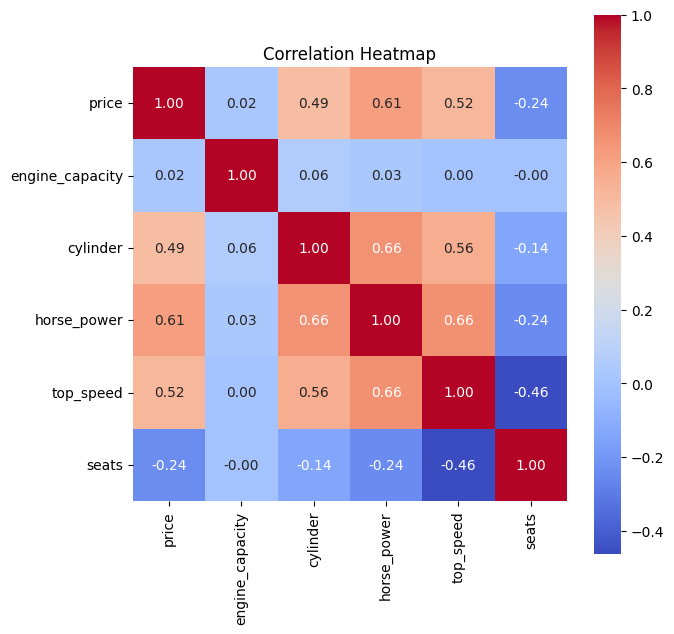

In [17]:

f_num = ['price', 'engine_capacity', 'cylinder', 'horse_power', 'top_speed', 'seats']

# Filter the dataset to include only the selected numerical columns
dataset_corr = df[f_num]

# Compute the correlation matrix
correlation_matrix = dataset_corr.corr()

# Plot the heatmap
plt.figure(figsize=(7, 7))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', square=True)
plt.title('Correlation Heatmap')
plt.show()

# 3. Building Regression Models 

## Linear Models

## Noninear Models

# Extra: Exploratory data analysis (EDA) + Interactivity

This part is inspired by the work from Federico's notebook: 
"Data Cleaning | EDA" 
Link: https://www.kaggle.com/code/fede123/data-cleaning-eda
